In [1]:
import pandas as pd
import numpy as np
from ProgSnap2 import ProgSnap2Dataset
from ProgSnap2 import PS2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import os
from os import path

In [2]:
semester = 'S19'
PATH = "data/CodeWorkout/" + semester

In [3]:
data = ProgSnap2Dataset(PATH)

In [4]:
main_table = data.get_main_table()
student_table = data.load_link_table('Subject')

In [5]:
main_table.head()

,Order,SubjectID,ToolInstances,ServerTimestamp,ServerTimezone,CourseID,CourseSectionID,AssignmentID,ProblemID,Attempt,CodeStateID,IsEventOrderingConsistent,EventType,Score,Compile.Result,CompileMessageType,CompileMessageData,EventID,ParentEventID,SourceLocation
3994,3994,00c54f9462673d4c09d2a88121860841,Java 8; CodeWorkout,2019-03-25T00:22:27,0,CS 1,1,492.0,32,1,026039890a9a87b488e8a023da480144c3f6cedf,True,Run.Program,1.0,NaN,NaN,NaN,32-88791,NaN,NaN
3995,3995,00c54f9462673d4c09d2a88121860841,Java 8; CodeWorkout,2019-03-25T00:22:27,0,CS 1,1,492.0,32,1,026039890a9a87b488e8a023da480144c3f6cedf,True,Compile,NaN,Success,NaN,NaN,32-88792,32-88791,NaN
10535,10535,00c54f9462673d4c09d2a88121860841,Java 8; CodeWorkout,2019-02-24T05:04:26,UTC,CS 1,1,439.0,234,1,a41126484e7a6ed1d768310250502f62c3fbc599,True,Run.Program,1.0,NaN,NaN,NaN,234-22182,NaN,NaN
10536,10536,00c54f9462673d4c09d2a88121860841,Java 8; CodeWorkout,2019-02-24T05:04:26,UTC,CS 1,1,439.0,234,1,a41126484e7a6ed1d768310250502f62c3fbc599,True,Compile,NaN,Success,NaN,NaN,234-22183,234-22182,NaN
27026,27026,00c54f9462673d4c09d2a88121860841,Java 8; CodeWorkout,2019-02-24T04:27:49,UTC,CS 1,1,439.0,13,1,6a78c051d22981f5f07c3dd1b56dab3757d26e2c,True,Run.Program,0.0,NaN,NaN,NaN,13-54894,NaN,NaN


In [6]:
# Get the SubjectIDs where the final grade is non-0
# A 0 grade indicates the student did not take the final
print(len(student_table.index))
subject_ids = set(student_table[student_table['X-Grade'] != 0][PS2.SubjectID].unique())
subject_ids = subject_ids.intersection(set(student_table['SubjectID'].unique()))
len(subject_ids)

381


348

We want to confirm that our selected students have a good and well-distributed number of attempts at all the problems in the dataset.

In [7]:
# First we check how many problems each student attempted
main_table_filtered = main_table[main_table[PS2.SubjectID].isin(subject_ids)]
problems_per_student = main_table_filtered.groupby(by=['SubjectID']).apply(lambda rows: len(rows[PS2.ProblemID].unique()))
# 75% of problems were attempted by at least 40 studens, so that's good
problems_per_student.describe()

count    346.000000
mean      42.855491
std       10.331712
min        1.000000
25%       40.000000
50%       48.500000
75%       50.000000
max       50.000000
dtype: float64

In [8]:
# Only 3 attempted fewer than 10 problems
sum(problems_per_student < 10)

3

In [9]:
# Next we see how many students attempted each problem
students_per_problem = main_table_filtered.groupby(by=['AssignmentID', 'ProblemID']).apply(lambda rows: len(rows[PS2.SubjectID].unique()))
students_per_problem.describe()

count     50.000000
mean     296.560000
std       14.642906
min      267.000000
25%      285.000000
50%      295.500000
75%      309.750000
max      324.000000
dtype: float64

<BarContainer object of 50 artists>

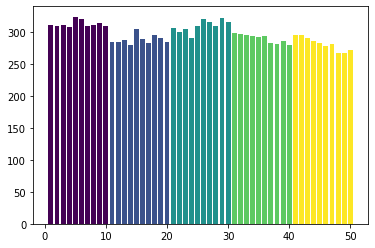

In [10]:
# Next we plot the number of attemptes on each problem (x) / assignment (color)
from matplotlib.cm import viridis

assignment_ids = list(students_per_problem.keys().map(lambda x: x[0]))
assignment_ids = [sorted(assignment_ids).index(x) for x in assignment_ids]
colors = [viridis((float(i)-min(assignment_ids))/(max(assignment_ids)-min(assignment_ids))) for i in assignment_ids]

# There's a slight drop-off by assignment, but overall they're well-attempted
plt.bar(range(1,51), students_per_problem, color=colors)

In [11]:
main_table_filtered[PS2.Score][0]

1.0

In [12]:
runs = main_table_filtered[main_table_filtered[PS2.EventType] == 'Run.Program']

def get_attempts(rows):
    scores = rows[PS2.Score]
    # If they scored 1, we return the first time they did so
    if (scores.max() == 1):
        # Argmax returns the first index of the highest score
        # Since the array is 0-indexed, we return +1
        return rows[PS2.Score].argmax() + 1
    return len(rows.index)
    

scores = runs.groupby([PS2.SubjectID, PS2.AssignmentID, PS2.ProblemID]).apply(get_attempts)
scores.describe()

count    14828.000000
mean         4.196318
std          5.879822
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         93.000000
dtype: float64

In [13]:
# Confirm that this is different than just the count of runs
runs.groupby([PS2.SubjectID, PS2.AssignmentID, PS2.ProblemID]).apply(lambda x: len(x.index)).describe()

count    14828.000000
mean         4.345090
std          6.076818
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         93.000000
dtype: float64

In [14]:
student_attempts = scores.to_frame('Attempts').reset_index()
student_attempts.head()

,SubjectID,AssignmentID,ProblemID,Attempts
0,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,1,8
1,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,3,6
2,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,5,7
3,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,12,2
4,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,13,17


In [15]:
correct_eventually = runs.groupby([PS2.SubjectID, PS2.AssignmentID, PS2.ProblemID])[PS2.Score].apply(lambda x: max(x) == 1)

In [16]:
def get_start_end_order(rows):
    return pd.Series({
        'StartEventOrder': min(rows[PS2.Order])
        # 'EndEventOrder': max(rows[PS2.Order])
    })

start_orders = main_table_filtered.groupby([PS2.SubjectID, PS2.AssignmentID, PS2.ProblemID]).apply(get_start_end_order)
start_orders

StartEventOrder
SubjectID                        AssignmentID ProblemID                 
036ad3e516c5bf3a4b3be35b137bcbb8 439.0        1                   120635
                                              3                   135624
                                              5                    66827
                                              12                   37923
                                              13                   30588
...                                                                  ...
ffb72475a81de0e95b910ffad039f5c2 502.0        64                   49816
                                              70                  113478
                                              71                  108282
                                              112                 110202
                                              118                  81273

[14828 rows x 1 columns]

In [17]:
student_scores = student_attempts.merge(correct_eventually.to_frame('CorrectEventually'), on=[PS2.SubjectID, PS2.AssignmentID, PS2.ProblemID])
student_scores = student_scores.merge(start_orders, on=[PS2.SubjectID, PS2.AssignmentID, PS2.ProblemID])
student_scores

,SubjectID,AssignmentID,ProblemID,Attempts,CorrectEventually,StartEventOrder
0,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,1,8,True,120635
1,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,3,6,True,135624
2,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,5,7,True,66827
3,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,12,2,True,37923
4,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,13,17,True,30588
...,...,...,...,...,...,...
14823,ffb72475a81de0e95b910ffad039f5c2,502.0,64,2,True,49816
14824,ffb72475a81de0e95b910ffad039f5c2,502.0,70,2,True,113478
14825,ffb72475a81de0e95b910ffad039f5c2,502.0,71,1,True,108282
14826,ffb72475a81de0e95b910ffad039f5c2,502.0,112,1,True,110202


In [18]:
student_scores.CorrectEventually.value_counts()

True     13790
False     1038
Name: CorrectEventually, dtype: int64

In [19]:
problem_attempt_75th = student_scores.groupby(PS2.ProblemID).apply(lambda x: x.Attempts.quantile(0.75))
problem_attempt_75th.head()

ProblemID
1      2.0
3      4.0
5      4.0
12     2.0
13    11.0
dtype: float64

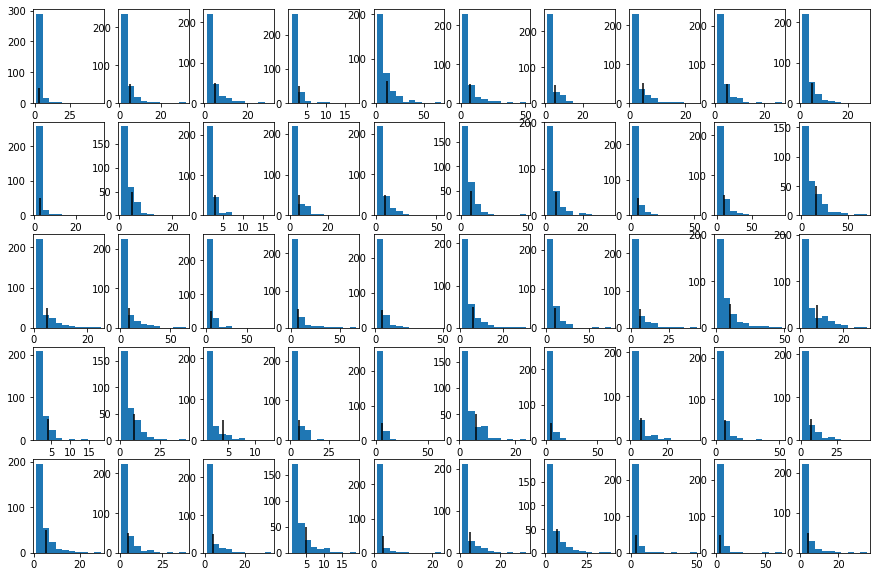

In [20]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 10]

problem_ids = list(student_scores.ProblemID.unique())
fig, axs = plt.subplots(5, 10)
for i in range(5):
    for j in range(10):
        problem_id = problem_ids[i * 10 + j]
        attempts = student_scores[student_scores[PS2.ProblemID] == problem_id].Attempts
        p75 = problem_attempt_75th[problem_id] + 1
        axs[i, j].hist(attempts)
        axs[i, j].vlines(p75, 0, 50)

In [21]:
cutoffs = student_scores['ProblemID'].apply(lambda x: problem_attempt_75th[x])
# TODO: Add ever correct!!
student_scores['Label'] = np.logical_and(student_scores['Attempts'] <= cutoffs, student_scores['CorrectEventually'])
student_scores['Label'].value_counts()

True     10931
False     3897
Name: Label, dtype: int64

(array([ 3.,  2.,  8., 13., 24., 38., 56., 46., 65., 91.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

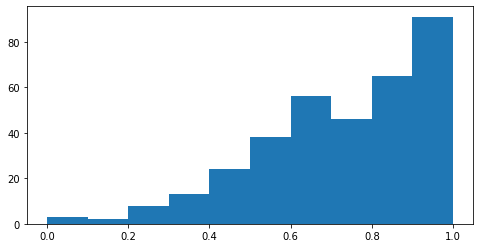

In [22]:
matplotlib.rcParams['figure.figsize'] = [8, 4]

# The percentage of struggling problems per student is well-distributed
plt.hist(student_scores.groupby(PS2.SubjectID)['Label'].mean())

In [81]:
runs_time = runs.copy()
problem_orders = runs.groupby([PS2.AssignmentID, PS2.ProblemID])[PS2.Order].median()
runs_time['TimeInt'] = pd.to_datetime(runs_time[PS2.ServerTimestamp]).apply(lambda x: x.value)
problem_times = runs_time.groupby([PS2.AssignmentID, PS2.ProblemID])['TimeInt'].median()
start_time = min(problem_times)
problem_times = (problem_times - start_time) / 10**9

problem_successes = runs_time[runs_time[PS2.Score] == 1].groupby([PS2.AssignmentID, PS2.ProblemID])['TimeInt'].median()
problem_successes = (problem_successes - start_time) / 10**9

In [82]:
problem_stats = problem_times.to_frame('MedTime').join(problem_successes.to_frame('MedSuccess')).join(problem_orders.to_frame('MedOrder')).reset_index()
problem_stats.head()

,AssignmentID,ProblemID,MedTime,MedSuccess,MedOrder
0,439.0,1,10500.0,8412.0,120061.0
1,439.0,3,8683.0,10464.0,134968.0
2,439.0,5,5753.0,6900.5,66162.0
3,439.0,12,3844.5,7733.5,37506.0
4,439.0,13,0.0,2022.5,29338.0


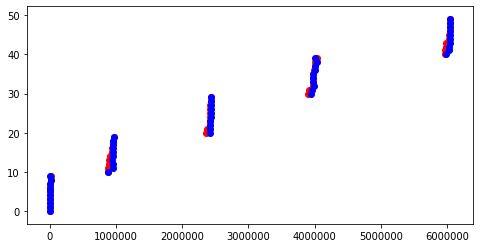

In [100]:
y = range(0, 50)
problem_stats.sort_values('MedTime', inplace=True)
plt.scatter(problem_stats['MedTime'], y, c='red')
plt.scatter(problem_stats['MedSuccess'], y, c='blue')

[439. 487. 492. 494. 502.]


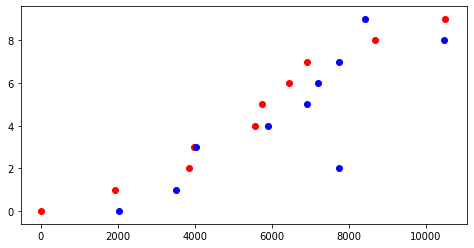

In [101]:
# Unfortunately, the last 3 problems aren't always easy to pick apart
print(problem_stats[PS2.AssignmentID].unique())
assignment1 = problem_stats[problem_stats[PS2.AssignmentID] == 439]
y = range(0, 10)
plt.scatter(assignment1['MedTime'], y, c='red')
plt.scatter(assignment1['MedSuccess'], y, c='blue')

In [95]:
last_problems = problem_stats.groupby(PS2.AssignmentID).apply(lambda rows: list(rows[PS2.ProblemID][rows['MedTime'].argsort()][-3:]))
last_problems

AssignmentID
439.0        [236, 3, 1]
487.0       [28, 21, 22]
492.0       [32, 31, 34]
494.0    [106, 108, 107]
502.0     [112, 118, 57]
dtype: object

In [96]:
test_problem_ids = [st for row in last_problems for st in row]
test_problem_ids

[236, 3, 1, 28, 21, 22, 32, 31, 34, 106, 108, 107, 112, 118, 57]

In [97]:
runs_time['IsLateProblem'] = runs_time[PS2.ProblemID].apply(lambda problem_id: problem_id in test_problem_ids)
runs_time.head()

,Order,SubjectID,ToolInstances,ServerTimestamp,ServerTimezone,CourseID,CourseSectionID,AssignmentID,ProblemID,Attempt,...,EventType,Score,Compile.Result,CompileMessageType,CompileMessageData,EventID,ParentEventID,SourceLocation,TimeInt,IsLateProblem
1559,1559,036ad3e516c5bf3a4b3be35b137bcbb8,Java 8; CodeWorkout,2019-03-24T02:46:17,0,CS 1,1,492.0,32,1,...,Run.Program,0.0000,NaN,NaN,NaN,32-86356,NaN,NaN,1553395577000000000,True
2088,2088,036ad3e516c5bf3a4b3be35b137bcbb8,Java 8; CodeWorkout,2019-03-24T15:59:50,0,CS 1,1,492.0,32,2,...,Run.Program,1.0000,NaN,NaN,NaN,32-86885,NaN,NaN,1553443190000000000,True
6379,6379,036ad3e516c5bf3a4b3be35b137bcbb8,Java 8; CodeWorkout,2019-04-09T17:46:54,0,CS 1,1,494.0,106,1,...,Run.Program,0.6250,NaN,NaN,NaN,106-35715,NaN,NaN,1554832014000000000,True
6600,6600,036ad3e516c5bf3a4b3be35b137bcbb8,Java 8; CodeWorkout,2019-04-10T02:08:31,0,CS 1,1,494.0,106,2,...,Run.Program,0.0000,NaN,NaN,NaN,106-35936,NaN,NaN,1554862111000000000,True
6604,6604,036ad3e516c5bf3a4b3be35b137bcbb8,Java 8; CodeWorkout,2019-04-10T02:08:48,0,CS 1,1,494.0,106,3,...,Run.Program,0.5625,NaN,NaN,NaN,106-35940,NaN,NaN,1554862128000000000,True


In [102]:
first_late_attempts = runs_time[runs_time['IsLateProblem']].groupby([PS2.AssignmentID, PS2.SubjectID])['TimeInt'].min()
first_late_attempts

AssignmentID  SubjectID                       
439.0         036ad3e516c5bf3a4b3be35b137bcbb8    1551057050000000000
              04c32d4d95425f73b3a1d6502aed4d48    1550959917000000000
              0503bf609757acf2e75aa8cbc0d8323b    1551068401000000000
              06d801cb636235b298c40029ad9921e7    1551062540000000000
              07ae4cca3f90a49347ccb5c1a82ff46f    1551056322000000000
                                                         ...         
502.0         f892447540d0e840049183faa3109b1b    1556916125000000000
              fa28c6cdf8dd6f41a657c3d7caa5c709    1556680134000000000
              fda6baab618b39821b678bd52ff26428    1557099430000000000
              feae21bb32b7b4aa690fab151b60b598    1556755185000000000
              ffb72475a81de0e95b910ffad039f5c2    1557099252000000000
Name: TimeInt, Length: 1491, dtype: int64

In [108]:
runs_late = runs_time.merge(first_late_attempts.to_frame('FirstLateAttempt'), on=[PS2.AssignmentID, PS2.SubjectID], how='left')
np.mean(runs_late['FirstLateAttempt'].isna())
# ~2% of student-assignments did not have a late attempt

0.016203883344456688

In [113]:
runs_late['IsLateAttempt'] = runs_late['TimeInt'] >= runs_late['FirstLateAttempt']

In [114]:
np.sum(~runs_late['IsLateAttempt'] & runs_late['IsLateProblem'])

0

In [116]:
# 30% of attempts at early problems occurred after the first attempt at a late problem
np.sum(runs_late['IsLateAttempt'] & ~runs_late['IsLateProblem']) / np.sum(~runs_late['IsLateProblem'])

0.3060754028962424

In [98]:
np.random.seed(1234)
subjects_sample = np.random.choice(runs_time[PS2.SubjectID].unique(), 20)
assignment_sample = runs_time[(runs_time[PS2.AssignmentID] == 439) & runs_time[PS2.SubjectID].isin(subjects_sample)]
assignment_sample.shape

(742, 22)

(-2, 2)

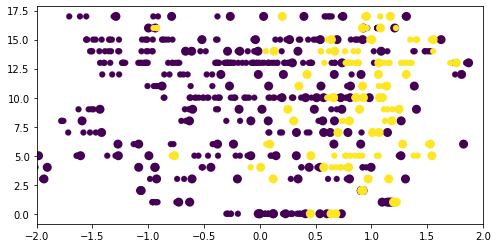

In [99]:
subject_ids = assignment_sample[PS2.SubjectID]
distinct_subject_ids = subject_ids.unique()
subject_indices = [sorted(distinct_subject_ids).index(x) for x in subject_ids]
colors = [viridis(float(i)) for i in assignment_sample['IsLateProblem']]
subject_times_norm = assignment_sample.groupby('SubjectID')['TimeInt'].transform(lambda x: (x - x.mean()) / x.std())
widths = list(assignment_sample[PS2.Score].apply(lambda x: 0.2 if x < 1 else 3))
plt.scatter(x=subject_times_norm, y=subject_indices, color=colors, linewidths=widths, edgecolors=None)
plt.xlim([-2, 2])

In [31]:
student_scores['IsLateProblem'] = student_scores[PS2.ProblemID].apply(lambda problem_id: problem_id in test_problem_ids)
student_scores.sort_values([PS2.SubjectID, PS2.AssignmentID, 'IsLateProblem', PS2.ProblemID], inplace=True)
student_scores.head(15)

,SubjectID,AssignmentID,ProblemID,Attempts,CorrectEventually,StartEventOrder,Label,IsLateProblem
2,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,5,7,True,66827,False,False
3,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,12,2,True,37923,True,False
4,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,13,17,True,30588,False,False
5,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,232,9,True,43989,False,False
6,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,233,1,True,61318,True,False
7,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,234,3,True,11846,True,False
8,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,235,1,True,70196,True,False
0,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,1,8,True,120635,False,True
1,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,3,6,True,135624,False,True
9,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,236,3,True,78397,True,True


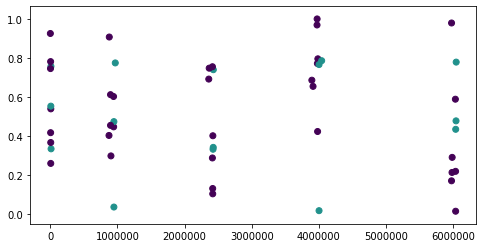

In [32]:
# Next we plot the number of attemptes on each problem (x) / assignment (color)
from matplotlib.cm import viridis

problem_ids = list(students_per_problem.keys().map(lambda x: x[1]))
colors = [viridis(0.5 if i in test_problem_ids else 1) for i in problem_ids]

# The late problems are the ones most to the right)
plt.scatter(problem_stats['MedTime'], np.random.uniform(size=50), color=colors)

In [33]:
train_ids, test_ids = train_test_split(list(subject_ids), test_size=0.25, random_state=1234)

In [34]:
student_scores_train = student_scores[student_scores[PS2.SubjectID].isin(train_ids)]
student_scores_test = student_scores[student_scores[PS2.SubjectID].isin(test_ids)]

In [35]:
early_train = student_scores_train[student_scores_train['IsLateProblem'] == False].drop(['IsLateProblem'], axis=1)
early_test = student_scores_test[student_scores_test['IsLateProblem'] == False].drop(['IsLateProblem'], axis=1)
late_train = student_scores_train[student_scores_train['IsLateProblem']].drop(['IsLateProblem', 'Attempts', 'CorrectEventually'], axis=1)
late_test = student_scores_test[student_scores_test['IsLateProblem']].drop(['IsLateProblem', 'Attempts', 'CorrectEventually'], axis=1)

In [36]:
early_train.head()

,SubjectID,AssignmentID,ProblemID,Attempts,CorrectEventually,StartEventOrder,Label
102,0503bf609757acf2e75aa8cbc0d8323b,439.0,5,1,True,67703,True
103,0503bf609757acf2e75aa8cbc0d8323b,439.0,12,1,True,38730,True
104,0503bf609757acf2e75aa8cbc0d8323b,439.0,13,2,True,36045,True
105,0503bf609757acf2e75aa8cbc0d8323b,439.0,232,5,True,47224,True
106,0503bf609757acf2e75aa8cbc0d8323b,439.0,233,8,True,62155,False


In [37]:
# TODO: scrub output for release
early_test.head()

,SubjectID,AssignmentID,ProblemID,Attempts,CorrectEventually,StartEventOrder,Label
2,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,5,7,True,66827,False
3,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,12,2,True,37923,True
4,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,13,17,True,30588,False
5,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,232,9,True,43989,False
6,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,233,1,True,61318,True


In [38]:
late_train.head()

,SubjectID,AssignmentID,ProblemID,StartEventOrder,Label
100,0503bf609757acf2e75aa8cbc0d8323b,439.0,1,121242,True
101,0503bf609757acf2e75aa8cbc0d8323b,439.0,3,136745,True
109,0503bf609757acf2e75aa8cbc0d8323b,439.0,236,79511,True
111,0503bf609757acf2e75aa8cbc0d8323b,492.0,31,153616,True
112,0503bf609757acf2e75aa8cbc0d8323b,492.0,32,5288,True


In [39]:
late_test.head()

,SubjectID,AssignmentID,ProblemID,StartEventOrder,Label
0,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,1,120635,False
1,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,3,135624,False
9,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,236,78397,True
12,036ad3e516c5bf3a4b3be35b137bcbb8,487.0,21,105003,False
13,036ad3e516c5bf3a4b3be35b137bcbb8,487.0,22,178437,False


In [40]:
base_path = os.path.join('data', 'Release', semester)
os.makedirs(os.path.join(base_path, 'Train'), exist_ok=True)
os.makedirs(os.path.join(base_path, 'Test'), exist_ok=True)

In [41]:
early_train.to_csv(os.path.join(base_path, 'Train', 'early.csv'), index=False)
late_train.to_csv(os.path.join(base_path, 'Train', 'late.csv'), index=False)
early_test.to_csv(os.path.join(base_path, 'Test', 'early.csv'), index=False)
late_test.drop('Label', axis=1).to_csv(os.path.join(base_path, 'Test', 'late.csv'), index=False)

In [42]:
data.save_subset(os.path.join(base_path, 'Train', 'Data'), lambda df: df[df[PS2.SubjectID].isin(train_ids)])

In [43]:
data.save_subset(os.path.join(base_path, 'Test', 'Data'), lambda df: df[df[PS2.SubjectID].isin(test_ids) & ~df[PS2.ProblemID].isin(test_problem_ids)], False)